In [1]:
import datetime as dtm
import requests
import pandas as pd
import time
import os
import numpy as np
import pickle
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
%matplotlib inline

In [2]:
intrinio_key_sand = 'OjYxNzRmMDQyZDM1NTVkOGEzMDAwYjA4MTI1YWY0ZThj'
intrinio_key_prod = 'OjM1MTMyNDljOTI4ODY4N2YxMGMzMmQ2OThiNGI5YzZj'

In [3]:
train_datefrom = dtm.datetime(2010, 1, 1)
train_dateto = dtm.datetime(2018, 1, 1)
valid_datefrom = dtm.datetime(2018, 1, 1)
valid_dateto = dtm.datetime(2019, 1, 1)
datefrom = dtm.datetime(2010, 1, 1)
dateto = dtm.datetime(2019, 1, 1)

In [4]:
list(range(datefrom.year, dateto.year+1))

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [43]:
stock_name = 'AAPL'

### Биржевые котировки

In [6]:
def request_stock_prices(name, datefrom, dateto, page=None):
    params = {
        "api_key": intrinio_key_sand,
        "start_date": datefrom.strftime("%Y-%m-%d"),
        "end_date": dateto.strftime("%Y-%m-%d"),
        "page": 100
    }
    if page is not None:
        params["next_page"] = page
    response = requests.request("get", "https://api-v2.intrinio.com/securities/{}/prices".format(name), params=params).json()
    result = response["stock_prices"]
    for entry in result:
        entry['date'] = dtm.datetime.strptime(entry["date"], "%Y-%m-%d")        
    if "next_page" in response and response["next_page"] is not None:
        result += (request_stock_prices(name, datefrom, dateto, response["next_page"]))
    return result

In [7]:
stock_daily = request_stock_prices(stock_name, datefrom, dateto)
stock_daily = pd.DataFrame(data=stock_daily, columns=['date', 'open', 'adj_open','close', 'adj_close','volume'])
stock_daily = stock_daily.sort_values('date').reset_index(drop=True)
stock_daily.assign(name=stock_name)
stock_daily.head()

,date,open,adj_open,close,adj_close,volume
0,2010-01-04,213.50,26.821769,214.01,26.885840,17633150.0
1,2010-01-05,214.79,26.983830,214.38,26.932323,21496572.0
2,2010-01-06,214.38,26.932323,210.97,26.503928,19719942.0
3,2010-01-07,211.68,26.593125,210.58,26.454933,17040332.0
4,2010-01-08,210.40,26.432320,211.98,26.630813,15995583.0


In [8]:
stock_daily['close_prev1'] = stock_daily['close'].shift(1)
stock_daily['adj_close_prev1'] = stock_daily['adj_close'].shift(1)
stock_daily['volume_prev1'] = stock_daily['volume'].shift(1)
stock_daily.head()

,date,open,adj_open,close,adj_close,volume,close_prev1,adj_close_prev1,volume_prev1
0,2010-01-04,213.50,26.821769,214.01,26.885840,17633150.0,NaN,NaN,NaN
1,2010-01-05,214.79,26.983830,214.38,26.932323,21496572.0,214.01,26.885840,17633150.0
2,2010-01-06,214.38,26.932323,210.97,26.503928,19719942.0,214.38,26.932323,21496572.0
3,2010-01-07,211.68,26.593125,210.58,26.454933,17040332.0,210.97,26.503928,19719942.0
4,2010-01-08,210.40,26.432320,211.98,26.630813,15995583.0,210.58,26.454933,17040332.0


### Технические индикаторы

In [9]:
def request_stock_technicals(stock_name,technical_name, datefrom, dateto, page=None, **kwargs):
    params = {
        "api_key": intrinio_key_sand,
        "start_date": datefrom.strftime("%Y-%m-%d"),
        "end_date": dateto.strftime("%Y-%m-%d"),
        "price_key": "open",
        "page": 100
    }
    params = {**params, **kwargs}
    if page is not None:
        params["next_page"] = page
    response = requests.request("get", "https://api-v2.intrinio.com/securities/{}/prices/technicals/{}".format(stock_name,technical_name), params=params).json()
    result = response["technicals"]
    for entry in result:
        entry_date = entry["date_time"].split('T')[0]
        entry['date'] = dtm.datetime.strptime(entry_date, "%Y-%m-%d")        
    if "next_page" in response and response["next_page"] is not None:
        result += request_stock_technicals(stock_name,technical_name, datefrom, dateto, page=response["next_page"], **kwargs)
    return result

In [10]:
technicals = [('sma', {'period':7}), ('sma', {'period':14}), ('sma', {'period':28}), 
              ('rsi', {'period':7}), ('rsi', {'period':14}), ('rsi', {'period':28}), 
              ('obv', {}), 
              ('adi', {}), 
              ('adx', {'short_period':3, 'long_period':7}), ('adx', {'short_period':7, 'long_period':14}), ('adx', {'short_period':7, 'long_period':28}),
              ('bb', {}), 
              ('kc', {'period':7}), ('kc', {'period':14}),('kc', {'period':28}),]
technicals_df = None
for technical_name, kwargs in technicals:
    print((technical_name, kwargs))
    current_tech = request_stock_technicals(stock_name, technical_name, datefrom, dateto, **kwargs)
    current_tech = pd.DataFrame(data=current_tech, columns=['date', technical_name])
    current_tech = current_tech.sort_values('date').reset_index(drop=True)
    current_tech[technical_name] = current_tech[technical_name].shift(1)
    column_name = technical_name + '-' + '-'.join(str(x) for x in kwargs.values())
    current_tech.columns = ['date', column_name+'_prev1']
    if technicals_df is None:
        technicals_df = current_tech
    else:
        technicals_df = pd.merge(technicals_df, current_tech, on='date')
technicals_df.head()

('sma', {'period': 7})
('sma', {'period': 14})
('sma', {'period': 28})
('rsi', {'period': 7})
('rsi', {'period': 14})
('rsi', {'period': 28})
('obv', {})
('adi', {})
('adx', {'short_period': 3, 'long_period': 7})
('adx', {'short_period': 7, 'long_period': 14})
('adx', {'short_period': 7, 'long_period': 28})
('bb', {})
('kc', {'period': 7})
('kc', {'period': 14})
('kc', {'period': 28})


,date,sma-7_prev1,sma-14_prev1,sma-28_prev1,rsi-7_prev1,rsi-14_prev1,rsi-28_prev1,obv-_prev1,adi-_prev1,adx-3-7_prev1,adx-7-14_prev1,adx-7-28_prev1,bb-_prev1,kc-7_prev1,kc-14_prev1,kc-28_prev1
0,2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,209.111429,202.412143,200.629286,73.518205,67.193386,60.534966,19347491.0,-3.210977e+07,19.920044,19.920044,19.920044,NaN,NaN,NaN,NaN
2,2010-01-06,211.054286,203.792143,201.046071,75.408606,68.338105,61.202147,40844063.0,-3.284469e+07,21.239888,21.239888,21.239888,NaN,NaN,NaN,NaN
3,2010-01-07,212.618571,205.122143,201.370357,73.464041,67.531570,60.863012,21124121.0,-5.062786e+07,21.613066,21.613066,21.613066,NaN,NaN,NaN,NaN
4,2010-01-08,212.694286,206.313571,201.591071,61.316099,62.315752,58.643783,4083789.0,-4.999245e+07,21.423076,21.423076,21.423076,NaN,NaN,NaN,NaN


In [11]:
stock_daily = pd.merge(stock_daily, technicals_df, on='date')
stock_daily.head()

,date,open,adj_open,close,adj_close,volume,close_prev1,adj_close_prev1,volume_prev1,sma-7_prev1,...,rsi-28_prev1,obv-_prev1,adi-_prev1,adx-3-7_prev1,adx-7-14_prev1,adx-7-28_prev1,bb-_prev1,kc-7_prev1,kc-14_prev1,kc-28_prev1
0,2010-01-04,213.50,26.821769,214.01,26.885840,17633150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,214.79,26.983830,214.38,26.932323,21496572.0,214.01,26.885840,17633150.0,209.111429,...,60.534966,19347491.0,-3.210977e+07,19.920044,19.920044,19.920044,NaN,NaN,NaN,NaN
2,2010-01-06,214.38,26.932323,210.97,26.503928,19719942.0,214.38,26.932323,21496572.0,211.054286,...,61.202147,40844063.0,-3.284469e+07,21.239888,21.239888,21.239888,NaN,NaN,NaN,NaN
3,2010-01-07,211.68,26.593125,210.58,26.454933,17040332.0,210.97,26.503928,19719942.0,212.618571,...,60.863012,21124121.0,-5.062786e+07,21.613066,21.613066,21.613066,NaN,NaN,NaN,NaN
4,2010-01-08,210.40,26.432320,211.98,26.630813,15995583.0,210.58,26.454933,17040332.0,212.694286,...,58.643783,4083789.0,-4.999245e+07,21.423076,21.423076,21.423076,NaN,NaN,NaN,NaN


###  Биржевые котировки S&P

In [12]:
def request_market_prices(name, datefrom, dateto, page=None):
    params = {
        "api_key": intrinio_key_sand,
        "start_date": datefrom.strftime("%Y-%m-%d"),
        "end_date": dateto.strftime("%Y-%m-%d"),
        "page": 100
    }
    if page is not None:
        params["next_page"] = page
    response = requests.request("get", "https://api-v2.intrinio.com/indices/stock_market/{}/historical_data/close_price".format(name), params=params).json()
    result = response["historical_data"]
    for entry in result:
        entry['date'] = dtm.datetime.strptime(entry["date"], "%Y-%m-%d")      
        entry['close'] = entry['value']
    if "next_page" in response and response["next_page"] is not None:
        result += request_market_prices(name, datefrom, dateto, response["next_page"])
    return result

In [13]:
market_daily = request_market_prices('$SPX', datefrom, dateto)
market_daily = pd.DataFrame(data=market_daily, columns=['date', 'close'])
market_daily = market_daily.sort_values('date').reset_index(drop=True)
market_daily['close'] = market_daily['close'].shift(1)
market_daily.columns=['date', 'close_prev1']
market_daily.head()

,date,close_prev1
0,2010-01-04,NaN
1,2010-01-05,1132.989990
2,2010-01-06,1136.520020
3,2010-01-07,1137.140015
4,2010-01-08,1141.689941


In [14]:
stock_daily = pd.merge(stock_daily, market_daily, on='date', suffixes=('', '_S&P'))
stock_daily.head()

,date,open,adj_open,close,adj_close,volume,close_prev1,adj_close_prev1,volume_prev1,sma-7_prev1,...,obv-_prev1,adi-_prev1,adx-3-7_prev1,adx-7-14_prev1,adx-7-28_prev1,bb-_prev1,kc-7_prev1,kc-14_prev1,kc-28_prev1,close_prev1_S&P
0,2010-01-04,213.50,26.821769,214.01,26.885840,17633150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,214.79,26.983830,214.38,26.932323,21496572.0,214.01,26.885840,17633150.0,209.111429,...,19347491.0,-3.210977e+07,19.920044,19.920044,19.920044,NaN,NaN,NaN,NaN,1132.989990
2,2010-01-06,214.38,26.932323,210.97,26.503928,19719942.0,214.38,26.932323,21496572.0,211.054286,...,40844063.0,-3.284469e+07,21.239888,21.239888,21.239888,NaN,NaN,NaN,NaN,1136.520020
3,2010-01-07,211.68,26.593125,210.58,26.454933,17040332.0,210.97,26.503928,19719942.0,212.618571,...,21124121.0,-5.062786e+07,21.613066,21.613066,21.613066,NaN,NaN,NaN,NaN,1137.140015
4,2010-01-08,210.40,26.432320,211.98,26.630813,15995583.0,210.58,26.454933,17040332.0,212.694286,...,4083789.0,-4.999245e+07,21.423076,21.423076,21.423076,NaN,NaN,NaN,NaN,1141.689941


### Мультипликаторы

In [15]:
def request_stock_fundamentals_report(name, year, page=None):
    params = {
        "api_key": intrinio_key_sand,
        "fiscal_year": year,
        "page": 100
    }
    if page is not None:
        params["next_page"] = page
    response = requests.request("get", "https://api-v2.intrinio.com/companies/{}/fundamentals".format(name), params=params).json()
    result = response["fundamentals"]
    for entry in result:
        entry['start_date'] = dtm.datetime.strptime(entry["start_date"], "%Y-%m-%d") if entry["start_date"] is not None else None
        entry['end_date'] = dtm.datetime.strptime(entry["end_date"], "%Y-%m-%d") if entry["end_date"] is not None else None   
    if "next_page" in response and response["next_page"] is not None:
        result += request_stock_fundamentals_report(name, year, response["next_page"])
    return result

def request_stock_financial_fundamentals(name,fundamental,year,  quarter, page=None):
    params = {
        "api_key": intrinio_key_sand,
        "fiscal_year": year,
        "page": 100
    }
    if page is not None:
        params["next_page"] = page
    request_id = name+'-'+fundamental+'-'+str(year)+'-'+quarter
    response = requests.request("get", "https://api-v2.intrinio.com/fundamentals/{}/standardized_financials".format(request_id), params=params).json()
    if "standardized_financials" not in response:
        return None
    result = response["standardized_financials"]
    result = [{'name':entry['data_tag']['name'], 'tag': entry['data_tag']['tag'], 'unit':entry['data_tag']['unit'], 'value':entry['value']} for entry in result]
    if "next_page" in response and response["next_page"] is not None:
        result += request_stock_financial_fundamentals(name, fundamental, year, response["next_page"])
    return result

In [16]:
fiscal_years= list(range(datefrom.year-1, dateto.year+1))
periods=['Q1', 'Q2', 'Q3', 'Q4']
tags=['revenuegrowth', 'freecashflow','debt','bookvaluepershare', 'pricetobook', 'pricetoearnings', 'evtoebitda',
      'ebitda', 'ebitdagrowth', 'grossmargin', 'efftaxrate', 'enterprisevalue', 'ltdebttoequity', 
      'pricetoearnings','roic', 'roe', 'debttototalcapital','altmanzscore', 'pretaxincomemargin', 'currentratio']

In [17]:
reports = request_stock_fundamentals_report(stock_name, 2017)
calculations_reports = pd.DataFrame(data=reports, columns=['fiscal_year', 'fiscal_period', 'start_date', 'end_date'])
calculations_reports.head()

,fiscal_year,fiscal_period,start_date,end_date
0,2017,FY,2016-09-25,2017-09-30
1,2017,FY,NaT,2017-09-30
2,2017,FY,2016-09-25,2017-09-30
3,2017,FY,2016-09-25,2017-09-30
4,2017,Q4,2017-07-02,2017-09-30


In [18]:
calculations_reports = pd.DataFrame(columns=['fiscal_year', 'fiscal_period', 'start_date', 'end_date'])
for year in fiscal_years:
    curr_reports = request_stock_fundamentals_report(stock_name, year)
    curr_reports = list(filter(lambda x: x['statement_code']=='calculations' and x['fiscal_period'] in periods, curr_reports))
    curr_reports = pd.DataFrame(data=curr_reports, columns=['fiscal_year', 'fiscal_period', 'start_date', 'end_date'])
    calculations_reports = pd.concat([calculations_reports, curr_reports])
calculations_reports.head()

,fiscal_year,fiscal_period,start_date,end_date
0,2009,Q4,2009-06-28,2009-09-26
1,2009,Q3,2009-03-29,2009-06-27
2,2009,Q2,2008-12-28,2009-03-28
3,2009,Q1,2008-09-28,2008-12-27
0,2010,Q4,2010-06-27,2010-09-25


In [19]:
fundamentals_example = request_stock_financial_fundamentals('AAPL', 'calculations', 2019, 'Q1')
fundamentals_example = pd.DataFrame(data=fundamentals_example, columns=['name','tag','unit','value'])
fundamentals_example['fiscal_year'] = 2019
fundamentals_example['fiscal_period'] = 'Q1'
pd.set_option('display.max_rows', len(fundamentals_example))
fundamentals_example

,name,tag,unit,value,fiscal_year,fiscal_period
0,Revenue Growth,revenuegrowth,percentage,-4.511100e-02,2019,Q1
1,Net Operating Profit after Tax (NOPAT),nopat,usd,1.949732e+10,2019,Q1
2,NOPAT Margin,nopatmargin,percentage,2.312570e-01,2019,Q1
3,Invested Capital,investedcapital,usd,-1.241300e+10,2019,Q1
4,Invested Capital Turnover,investedcapitalturnover,float,-1.498740e+01,2019,Q1
5,Increase / (Decrease) in Invested Capital,investedcapitalincreasedecrease,usd,1.008500e+10,2019,Q1
6,Free Cash Flow to Firm (FCFF),freecashflow,usd,9.412318e+09,2019,Q1
7,Net Nonoperating Expense (NNE),netnonopex,usd,-4.676818e+08,2019,Q1
8,Net Nonoperating Obligations (NNO),netnonopobligations,usd,-1.303050e+11,2019,Q1
9,Earnings before Interest and Taxes (EBIT),ebit,usd,2.390600e+10,2019,Q1


In [20]:
fundamentals = None
for year in fiscal_years:
    for period in periods:
        curr_fundamentals = request_stock_financial_fundamentals('AAPL', 'calculations', year, period)
        if curr_fundamentals is None:
            continue
        curr_fundamentals = list(filter(lambda x: x['tag'] in tags, curr_fundamentals))
        curr_fundamentals = pd.DataFrame(data=curr_fundamentals, columns=['name','tag','unit','value'])
        curr_fundamentals['fiscal_year'] = year
        curr_fundamentals['fiscal_period'] = period
        if fundamentals is None:
            fundamentals = curr_fundamentals
        else:
            fundamentals = pd.concat([fundamentals, curr_fundamentals])

In [21]:
fundmentals_report = pd.merge(fundamentals, calculations_reports, on=['fiscal_year', 'fiscal_period'])
fundmentals_report.head()

,name,tag,unit,value,fiscal_year,fiscal_period,start_date,end_date
0,Revenue Growth,revenuegrowth,percentage,0.000000e+00,2009,Q1,2008-09-28,2008-12-27
1,Free Cash Flow to Firm (FCFF),freecashflow,usd,0.000000e+00,2009,Q1,2008-09-28,2008-12-27
2,"Earnings before Interest, Taxes, Depreciation ...",ebitda,usd,3.427000e+09,2009,Q1,2008-09-28,2008-12-27
3,Total Debt,debt,usd,0.000000e+00,2009,Q1,2008-09-28,2008-12-27
4,Book Value per Share,bookvaluepershare,usdpershare,0.000000e+00,2009,Q1,2008-09-28,2008-12-27


In [22]:
fundmentals_report_tomerge = fundmentals_report.drop(['name', 'unit'], axis=1)
fundmentals_report_tomerge = pd.pivot_table(fundmentals_report_tomerge, 
                                            index=['start_date', 'end_date','fiscal_year', 'fiscal_period'], 
                                            columns='tag', values='value').reset_index()
fundmentals_report_tomerge.head()

tag,start_date,end_date,fiscal_year,fiscal_period,altmanzscore,bookvaluepershare,currentratio,debt,debttototalcapital,ebitda,...,evtoebitda,freecashflow,grossmargin,ltdebttoequity,pretaxincomemargin,pricetobook,pricetoearnings,revenuegrowth,roe,roic
0,2008-09-28,2008-12-27,2009,Q1,0.0000,0.0000,0.0000,0.0,0.0,3.427000e+09,...,0.0000,0.000000e+00,0.379377,0.0,0.274327,0.0000,0.0000,0.000000,0.000000,0.0
1,2008-12-28,2009-03-28,2009,Q2,0.0000,0.0000,0.0000,0.0,0.0,2.567000e+09,...,0.0000,0.000000e+00,0.399273,0.0,0.262660,0.0000,0.0000,0.000000,0.000000,0.0
2,2009-03-29,2009-06-27,2009,Q3,0.0000,28.4746,2.1109,0.0,0.0,2.874000e+09,...,0.0000,7.020257e+09,0.409184,0.0,0.276556,0.0000,0.0000,0.304126,0.000000,0.0
3,2009-06-28,2009-09-26,2009,Q4,7.8597,34.8840,2.7425,0.0,0.0,3.932000e+09,...,8.7086,0.000000e+00,0.418203,0.0,0.305480,4.5974,17.6639,0.000000,0.305356,0.0
4,2009-09-27,2009-12-26,2010,Q1,7.8877,38.8874,2.5450,0.0,0.0,4.967000e+09,...,9.0142,7.406571e+09,0.408787,0.0,0.303386,4.7272,18.0684,0.320118,0.000000,0.0


In [23]:
stock_daily_cop = stock_daily.copy()
stock_daily_cop = stock_daily_cop.assign(key=1)
stock_daily_cop.head()

,date,open,adj_open,close,adj_close,volume,close_prev1,adj_close_prev1,volume_prev1,sma-7_prev1,...,adi-_prev1,adx-3-7_prev1,adx-7-14_prev1,adx-7-28_prev1,bb-_prev1,kc-7_prev1,kc-14_prev1,kc-28_prev1,close_prev1_S&P,key
0,2010-01-04,213.50,26.821769,214.01,26.885840,17633150.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2010-01-05,214.79,26.983830,214.38,26.932323,21496572.0,214.01,26.885840,17633150.0,209.111429,...,-3.210977e+07,19.920044,19.920044,19.920044,NaN,NaN,NaN,NaN,1132.989990,1
2,2010-01-06,214.38,26.932323,210.97,26.503928,19719942.0,214.38,26.932323,21496572.0,211.054286,...,-3.284469e+07,21.239888,21.239888,21.239888,NaN,NaN,NaN,NaN,1136.520020,1
3,2010-01-07,211.68,26.593125,210.58,26.454933,17040332.0,210.97,26.503928,19719942.0,212.618571,...,-5.062786e+07,21.613066,21.613066,21.613066,NaN,NaN,NaN,NaN,1137.140015,1
4,2010-01-08,210.40,26.432320,211.98,26.630813,15995583.0,210.58,26.454933,17040332.0,212.694286,...,-4.999245e+07,21.423076,21.423076,21.423076,NaN,NaN,NaN,NaN,1141.689941,1


In [24]:
fundmentals_report_tomerge = fundmentals_report_tomerge.assign(key=1)
fundmentals_report_tomerge.head()

tag,start_date,end_date,fiscal_year,fiscal_period,altmanzscore,bookvaluepershare,currentratio,debt,debttototalcapital,ebitda,...,freecashflow,grossmargin,ltdebttoequity,pretaxincomemargin,pricetobook,pricetoearnings,revenuegrowth,roe,roic,key
0,2008-09-28,2008-12-27,2009,Q1,0.0000,0.0000,0.0000,0.0,0.0,3.427000e+09,...,0.000000e+00,0.379377,0.0,0.274327,0.0000,0.0000,0.000000,0.000000,0.0,1
1,2008-12-28,2009-03-28,2009,Q2,0.0000,0.0000,0.0000,0.0,0.0,2.567000e+09,...,0.000000e+00,0.399273,0.0,0.262660,0.0000,0.0000,0.000000,0.000000,0.0,1
2,2009-03-29,2009-06-27,2009,Q3,0.0000,28.4746,2.1109,0.0,0.0,2.874000e+09,...,7.020257e+09,0.409184,0.0,0.276556,0.0000,0.0000,0.304126,0.000000,0.0,1
3,2009-06-28,2009-09-26,2009,Q4,7.8597,34.8840,2.7425,0.0,0.0,3.932000e+09,...,0.000000e+00,0.418203,0.0,0.305480,4.5974,17.6639,0.000000,0.305356,0.0,1
4,2009-09-27,2009-12-26,2010,Q1,7.8877,38.8874,2.5450,0.0,0.0,4.967000e+09,...,7.406571e+09,0.408787,0.0,0.303386,4.7272,18.0684,0.320118,0.000000,0.0,1


In [25]:
merged = pd.merge(stock_daily_cop, fundmentals_report_tomerge, on='key')
merged.head()

,date,open,adj_open,close,adj_close,volume,close_prev1,adj_close_prev1,volume_prev1,sma-7_prev1,...,evtoebitda,freecashflow,grossmargin,ltdebttoequity,pretaxincomemargin,pricetobook,pricetoearnings,revenuegrowth,roe,roic
0,2010-01-04,213.5,26.821769,214.01,26.88584,17633150.0,NaN,NaN,NaN,NaN,...,0.0000,0.000000e+00,0.379377,0.0,0.274327,0.0000,0.0000,0.000000,0.000000,0.0
1,2010-01-04,213.5,26.821769,214.01,26.88584,17633150.0,NaN,NaN,NaN,NaN,...,0.0000,0.000000e+00,0.399273,0.0,0.262660,0.0000,0.0000,0.000000,0.000000,0.0
2,2010-01-04,213.5,26.821769,214.01,26.88584,17633150.0,NaN,NaN,NaN,NaN,...,0.0000,7.020257e+09,0.409184,0.0,0.276556,0.0000,0.0000,0.304126,0.000000,0.0
3,2010-01-04,213.5,26.821769,214.01,26.88584,17633150.0,NaN,NaN,NaN,NaN,...,8.7086,0.000000e+00,0.418203,0.0,0.305480,4.5974,17.6639,0.000000,0.305356,0.0
4,2010-01-04,213.5,26.821769,214.01,26.88584,17633150.0,NaN,NaN,NaN,NaN,...,9.0142,7.406571e+09,0.408787,0.0,0.303386,4.7272,18.0684,0.320118,0.000000,0.0


In [26]:
merged.tail()

,date,open,adj_open,close,adj_close,volume,close_prev1,adj_close_prev1,volume_prev1,sma-7_prev1,...,evtoebitda,freecashflow,grossmargin,ltdebttoequity,pretaxincomemargin,pricetobook,pricetoearnings,revenuegrowth,roe,roic
92819,2018-12-31,158.53,157.852997,157.74,157.066371,35003466.0,156.23,155.562819,42291424.0,156.15,...,9.0245,1.585080e+10,0.384085,0.7412,0.306140,6.1075,16.9474,0.126891,0.370705,0.0
92820,2018-12-31,158.53,157.852997,157.74,157.066371,35003466.0,156.23,155.562819,42291424.0,156.15,...,8.7910,7.858758e+09,0.383107,0.7989,0.264455,6.6019,15.7102,0.155796,0.408630,0.0
92821,2018-12-31,158.53,157.852997,157.74,157.066371,35003466.0,156.23,155.562819,42291424.0,156.15,...,9.5346,4.378286e+09,0.383385,0.8450,0.249395,7.8448,16.0682,0.173031,0.453726,0.0
92822,2018-12-31,158.53,157.852997,157.74,157.066371,35003466.0,156.23,155.562819,42291424.0,156.15,...,11.9011,1.016637e+10,0.382893,0.8748,0.261065,10.4529,18.8137,0.196295,0.493636,0.0
92823,2018-12-31,158.53,157.852997,157.74,157.066371,35003466.0,156.23,155.562819,42291424.0,156.15,...,7.5276,9.412318e+09,0.379919,0.7888,0.283549,6.2985,12.4942,-0.045111,0.460543,0.0


In [27]:
merged = merged.query('(date >= start_date and date <= end_date)')
merged = merged.drop(['key','start_date','end_date','fiscal_year','fiscal_period'], axis=1).reset_index(drop=True)
merged.head()

,date,open,adj_open,close,adj_close,volume,close_prev1,adj_close_prev1,volume_prev1,sma-7_prev1,...,evtoebitda,freecashflow,grossmargin,ltdebttoequity,pretaxincomemargin,pricetobook,pricetoearnings,revenuegrowth,roe,roic
0,2010-01-04,213.50,26.821769,214.01,26.885840,17633150.0,NaN,NaN,NaN,NaN,...,9.0954,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0
1,2010-01-05,214.79,26.983830,214.38,26.932323,21496572.0,214.01,26.885840,17633150.0,209.111429,...,9.0954,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0
2,2010-01-06,214.38,26.932323,210.97,26.503928,19719942.0,214.38,26.932323,21496572.0,211.054286,...,9.0954,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0
3,2010-01-07,211.68,26.593125,210.58,26.454933,17040332.0,210.97,26.503928,19719942.0,212.618571,...,9.0954,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0
4,2010-01-08,210.40,26.432320,211.98,26.630813,15995583.0,210.58,26.454933,17040332.0,212.694286,...,9.0954,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0


In [28]:
stock_daily = merged

### Подготовка к обучению

In [29]:
data = stock_daily.drop(0).reset_index(drop=True)
data['date'] = data['date'].map(lambda x: x.timestamp())

In [30]:
from sklearn.preprocessing import MinMaxScaler

to_normalize = ['volume_prev1', 'ebitda']
data['date_norm'] = MinMaxScaler().fit_transform(data['date'].as_matrix().reshape(-1, 1))
data['volume_prev1'] = MinMaxScaler().fit_transform(data['volume_prev1'].as_matrix().reshape(-1, 1))
data['ebitda'] = MinMaxScaler().fit_transform(data['ebitda'].as_matrix().reshape(-1, 1))

In [31]:
data.head()

,date,open,adj_open,close,adj_close,volume,close_prev1,adj_close_prev1,volume_prev1,sma-7_prev1,...,freecashflow,grossmargin,ltdebttoequity,pretaxincomemargin,pricetobook,pricetoearnings,revenuegrowth,roe,roic,date_norm
0,1.262639e+09,214.79,26.983830,214.38,26.932323,21496572.0,214.01,26.885840,0.065154,209.111429,...,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0,0.000000
1,1.262725e+09,214.38,26.932323,210.97,26.503928,19719942.0,214.38,26.932323,0.086127,211.054286,...,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0,0.000305
2,1.262812e+09,211.68,26.593125,210.58,26.454933,17040332.0,210.97,26.503928,0.076482,212.618571,...,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0,0.000610
3,1.262898e+09,210.40,26.432320,211.98,26.630813,15995583.0,210.58,26.454933,0.061936,212.694286,...,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0,0.000915
4,1.263157e+09,212.97,26.755186,210.11,26.395887,16508195.0,211.98,26.630813,0.056265,212.372857,...,5.391852e+09,0.416698,0.0,0.298467,4.7625,17.332,0.486019,0.0,0.0,0.001830


In [32]:
train_data = data[data['date'] <= train_dateto.timestamp()]
X_train = train_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_train))
Y_train_regr = train_data['close']
Y_train_classify = train_data['close'] > train_data['open']

2012


In [33]:
valid_data = data[data['date'] > train_dateto.timestamp()]
X_valid = valid_data.drop(['date','close','adj_close', 'volume'],axis=1)
print(len(X_valid))
Y_valid_regr = valid_data['close']
Y_valid_classify =valid_data['close'] > valid_data['open']

250


In [35]:
ts = time.time()

filename = 'xgboost_regr.pickle.dat'
if os.path.isfile(filename) and False:
    model_regr = pickle.load(open(filename, "rb"))
else:
    model_regr = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42)

    model_regr.fit(
        X_train, 
        Y_train_regr, 
        eval_set=[(X_train, Y_train_regr), (X_valid, Y_valid_regr)], 
        eval_metric='mae',
        verbose=True, 
        early_stopping_rounds = 10)
    pickle.dump(model_regr, open(filename, "wb"))
    
time.time() - ts

[0]	validation_0-mae:263.125	validation_1-mae:167.664
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:236.923	validation_1-mae:149.594
[2]	validation_0-mae:213.269	validation_1-mae:131.155
[3]	validation_0-mae:191.992	validation_1-mae:113.674
[4]	validation_0-mae:172.74	validation_1-mae:101.092
[5]	validation_0-mae:155.478	validation_1-mae:90.4043
[6]	validation_0-mae:140.029	validation_1-mae:80.7894
[7]	validation_0-mae:126.027	validation_1-mae:74.6701
[8]	validation_0-mae:113.488	validation_1-mae:67.9163
[9]	validation_0-mae:102.142	validation_1-mae:62.2383
[10]	validation_0-mae:91.9743	validation_1-mae:57.4603
[11]	validation_0-mae:82.7779	validation_1-mae:52.2539
[12]	validation_0-mae:74.5869	validation_1-mae:45.3376
[13]	validation_0-mae:67.1948	validation_1-mae:40.927
[14]	validation_0-mae:60.5094	validation_1-mae:37.7362
[15]	validation_0-mae:54.5206	

0.5893154144287109

In [40]:
ts = time.time()

filename = 'xgboost_classif.pickle.dat'
if os.path.isfile(filename) and False:
    model_class = pickle.load(open(filename, "rb"))
else:
    model_class = XGBClassifier(  
        
        seed=42)

    model_class.fit(
        X_train, 
        Y_train_classify, 
        eval_set=[(X_train, Y_train_classify), (X_valid, Y_valid_classify)], 
        verbose=True, 
        
        eval_metric='error',
        early_stopping_rounds = 10)
    pickle.dump(model_class, open(filename, "wb"))
    
time.time() - ts

[0]	validation_0-error:0.43837	validation_1-error:0.504
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.437873	validation_1-error:0.504
[2]	validation_0-error:0.406064	validation_1-error:0.504
[3]	validation_0-error:0.403082	validation_1-error:0.504
[4]	validation_0-error:0.395626	validation_1-error:0.504
[5]	validation_0-error:0.384195	validation_1-error:0.488
[6]	validation_0-error:0.392147	validation_1-error:0.504
[7]	validation_0-error:0.38171	validation_1-error:0.488
[8]	validation_0-error:0.393638	validation_1-error:0.508
[9]	validation_0-error:0.382207	validation_1-error:0.512
[10]	validation_0-error:0.37674	validation_1-error:0.512
[11]	validation_0-error:0.372266	validation_1-error:0.52
[12]	validation_0-error:0.37326	validation_1-error:0.508
[13]	validation_0-error:0.380716	validation_1-error:0.504
[14]	validation_0-error:0.379722	validatio

0.19148802757263184

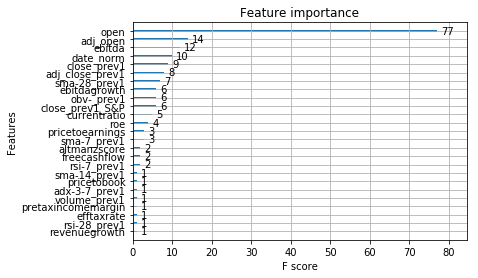

In [37]:
plot_importance(booster=model_regr)

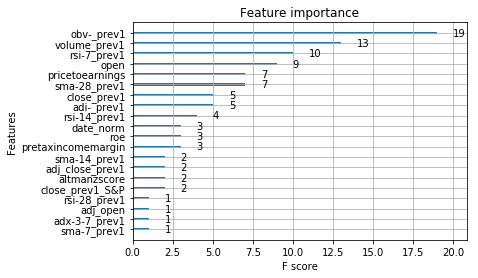

In [38]:
plot_importance(booster=model_class)